In [ ]:
# sampling methodology template script 
# 20230913
# carverd@colostate.edu

In [2]:
# libraries 
import pandas
import numpy
import datetime 

In [1]:
#  i was having issues with the kernal not capture the correct libraries, dug this out of this post
# https://github.com/jupyter/notebook/issues/2359
import sys
sys.path.append('C:/Users/carverd/Documents/GitHub/Agroforestry/agro-env/Lib/site-packages')

In [3]:
import ee
# ee.Authenticate()
ee.Initialize()

In [4]:
import geemap

In [5]:
import geopandas

In [6]:
# set sample grid ID 
aoiID = 'X12-601'
# set some basic parameter for workflow 
coordsAbsence = numpy.nan
coordsPresence = numpy.nan
today = datetime.date.today()
name = "test"

In [7]:
# load the sampling reference grid 12kGrid
grid = geopandas.read_file("../data/griddedFeatures/twelve_mi_grid_uid.gpkg")
# load the sampling grid 
df = pandas.read_csv("../sampling/samplingReferenceSheet_12b.csv", index_col='ID',
                 dtype = {'presence': str, 'absence': str, 'sampledBy': str,
                         'dateSampled' :str})

<AxesSubplot:>

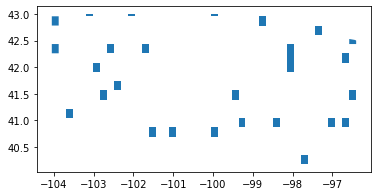

In [8]:
# quick map of the sampling locations 
mask = grid['Unique_ID'].isin(df.index)
sp1 = grid[mask]
sp1.plot()

In [9]:
# Generaete map objects based on the define reference grid 
aoi_pandas = grid[grid.Unique_ID == aoiID]
# as ee object
aoi_ee = geemap.gdf_to_ee(aoi_pandas)

In [10]:
# compile naip imagery 
# 2010, 2016, 2020 for sample time periods 
naip2020 = geemap.get_annual_NAIP(2020).filterBounds(aoi_ee).mosaic()
naip2015 = geemap.get_annual_NAIP(2016).filterBounds(aoi_ee).mosaic()
naip2010 = geemap.get_annual_NAIP(2010).filterBounds(aoi_ee).mosaic()
# print(naip2020)


In [11]:
# compile Naip visualizations 
visParamsFalse = {"bands":['N', 'R', 'G']};
visParamsTrue = {"bands":['R', 'G', 'B']};

In [12]:
### Tree presence sampling 
MapPresence = geemap.Map()
MapPresence.add_basemap("SATELLITE")
MapPresence.centerObject(ee_object = aoi_ee, zoom = 10)
MapPresence.addLayer(naip2020, visParamsTrue, name = "rgb2020")
MapPresence.addLayer(naip2020, visParamsFalse, name = "false2020")
# testing the 2015 layer
MapPresence.addLayer(naip2015, visParamsTrue, name = "rgb2015")
MapPresence.addLayer(naip2010, visParamsTrue, name = "rgb2010")

MapPresence

Map(center=[42.3479205803485, -98.05372930749978], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# extract presence objects 
presence = ee.FeatureCollection(MapPresence.draw_features)
coordsPresence = geemap.ee_to_gdf(presence)
presence_points = []

for index, row in coordsPresence.iterrows():
    presence_points.append([row.geometry.x, row.geometry.y])
presence_points

In [32]:
### 2020 absence sampling 
MapAbsence = geemap.Map()
MapAbsence.add_basemap("SATELLITE")
MapAbsence.centerObject(ee_object = aoi_ee, zoom = 10)
MapAbsence.addLayer(naip2020, visParamsTrue, name = "rgb2020")
MapAbsence.addLayer(naip2020, visParamsFalse, name = "false2020")
# testing the 2015 layer
MapAbsence.addLayer(naip2015, visParamsTrue, name = "rgb2015")
MapAbsence.addLayer(naip2010, visParamsTrue, name = "rgb2010")

MapAbsence

Map(center=[42.3479205803485, -98.05372930749978], controls=(WidgetControl(options=['position', 'transparent_b…

In [33]:
# extract absence objects 
# extract presence objects 
absence = ee.FeatureCollection(MapAbscence.draw_features)
coordsAbsence = geemap.ee_to_gdf(absence)
absence_points = []

for index, row in coordsAbsence.iterrows():
    absence_points.append([row.geometry.x, row.geometry.y])
absence_points

NameError: name 'MapAbscence' is not defined

In [ ]:
# binding values to the specific locations 
pLoc = df.loc[df.index==aoiID,'presence']
aLoc = df.loc[df.index==aoiID,'absence']

# this is here for a manuel overwrite of the exising data. Change parameter to True. !!! besure to change back on save or feautres 
# will continuously be overwritten. 
overwrite = False 

# add presence values
if pd.isna(pLoc[0]) or overwrite is True:
    df.loc[df.index==aoiID,'presence'] = str(presence_points)
    
# add absence values 
if pd.isna(aLoc[0]) or overwrite is True:
    df.loc[df.index==aoiID,'absence'] = str(absence_points)
    
# add data and samplers name 
df.loc[df.index==aoiID,'sampledBy'] = name 
df.loc[df.index==aoiID,'dateSampled'] = today 

df
# export the csv to save values 
df.to_csv("../sampling/samplingReferenceSheet_12b.csv", index = True)